## Group Name:
## Student 1:
## Student 2:

# Imports


In [1]:
import torch
from torch import nn
from torch.autograd import Variable

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle

# Predictor setting


The COVID-19 crisis has proved to be one of the world’s most critical challenges — a challenge bigger than any one government or organization can tackle on its own. Countries around the world are not equipped to implement health and safety interventions and policies that effectively protect both their citizens and economies.
 
In order to fight this pandemic, we need access to localized, data-driven planning systems and the latest in artificial intelligence (AI) to help decision-makers develop and implement robust Intervention Plans (IPs) that successfully reduce infection cases and minimize economic impact.

**Intervention Plan (IP)**: A plan of action or schedule for setting and resetting various intervention policies at various strengths or stringency.

**Predictor Model**: Given a time sequence of IPs in effect, and other data like a time sequence of number of cases, a predictor model will estimate the number of cases in the future.

## Intervention Plan

An intervention plan consists of a set of [containment and closure policies](https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md#containment-and-closure-policies), as well as [health system policies](https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md#health-system-policies). Check out the links to understand what these policies correspond to and how they are coded.

For instance the **C1M_School closing** policy, which records closings of schools and universities, is coded like that:

| Code      | Meaning     |
| :-------- | :---------- |
|  0        | no measures |
|  1        | recommend closing|
|  2        | require closing (only some levels or categories, eg just high school, or just public schools) |
|  3        | require closing all levels |
| Blank     | no data |

Interventions plans are recorded daily for each countries and sometimes for regions. For this competition, the following policies are considered:

In [2]:
IP_COLUMNS = ["C1M_School closing", "C2M_Workplace closing",
"C3M_Cancel public events", "C4M_Restrictions on gatherings",
"C5M_Close public transport", "C6M_Stay at home requirements",
"C7M_Restrictions on internal movement", "C8EV_International travel controls",
"H1_Public information campaigns", "H2_Testing policy", "H3_Contact tracing"]

## Dataset

The university of Oxford Blavatnik School of Government is [tracking coronavirus government responses](https://www.bsg.ox.ac.uk/research/research-projects/coronavirus-government-response-tracker). They have assembled a [data set](https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv) containing historical data since January 1st, 2020 for the number of cases and IPs for most countries in the world.

We will be working with data from 2022.

In [3]:
df = pd.read_csv("./data/trn_data.csv")
df.sample(3)

,CountryName,Date,ConfirmedCases,C1M_School closing,C2M_Workplace closing,C3M_Cancel public events,C4M_Restrictions on gatherings,C5M_Close public transport,C6M_Stay at home requirements,C7M_Restrictions on internal movement,C8EV_International travel controls,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing
30252,Tonga,2022-01-14,1.0,1.0,0.0,1.0,3.0,0.0,2.0,0.0,4.0,2.0,3.0,1.0
13922,Indonesia,2022-03-05,5723858.0,1.0,1.0,2.0,3.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0
9581,Spain,2022-02-12,10604200.0,1.0,1.0,1.0,4.0,0.0,0.0,0.0,1.0,2.0,3.0,1.0


### Computing the daily change in cases
The **ConfirmedCases** column reports the total number of cases since the beginning of the epidemic for each country, region and day. From this number we can compute the daily change in confirmed cases by doing:

\begin{equation*}
NewCases_t = ConfirmedCases_t - ConfirmedCases_{t-1}
\end{equation*}

In [4]:
df["NewCases"] = df.groupby(["CountryName"])["ConfirmedCases"].diff().fillna(0)

Fill any missing case values by interpolation and setting NaNs to 0

In [5]:
df.update(df.groupby("CountryName")["NewCases"].apply(
    lambda group: group.interpolate()).fillna(0))

## Visualizing the data

### Listing the number of cases and IPs

Select columns of the DataFrame using indexing, and then sample 5 random rows.

In [6]:
ID_COLUMNS = ["CountryName", "Date"]
CASES_COLUMNS = ["NewCases", "ConfirmedCases"]

df[ID_COLUMNS + CASES_COLUMNS + IP_COLUMNS].sample(5)

,CountryName,Date,NewCases,ConfirmedCases,C1M_School closing,C2M_Workplace closing,C3M_Cancel public events,C4M_Restrictions on gatherings,C5M_Close public transport,C6M_Stay at home requirements,C7M_Restrictions on internal movement,C8EV_International travel controls,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing
14384,Ireland,2022-06-15,7765.0,1578284.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
19934,Mexico,2022-05-16,6789.0,5752441.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0
10555,France,2022-04-27,54822.0,27719872.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,1.0
29799,Tajikistan,2022-04-11,0.0,17786.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
1836,Burundi,2022-02-07,180.0,37742.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,2.0,1.0


### Listing the latest historical daily new cases for a given country and region
For instance, for country **United States**, region **Texas**, the latest available changes in confirmed cases are:

In [7]:
country = "United States"
country_df = df[df["CountryName"]==country]
country_df[["CountryName", "Date", "ConfirmedCases", "NewCases"]].tail(10)


,CountryName,Date,ConfirmedCases,NewCases
32030,United States,2022-06-21,86573005.0,111307.0
32031,United States,2022-06-22,86758445.0,185440.0
32032,United States,2022-06-23,86896776.0,138331.0
32033,United States,2022-06-24,87014247.0,117471.0
32034,United States,2022-06-25,87055090.0,40843.0
32035,United States,2022-06-26,87077328.0,22238.0
32036,United States,2022-06-27,87237506.0,160178.0
32037,United States,2022-06-28,87335336.0,97830.0
32038,United States,2022-06-29,87525406.0,190070.0
32039,United States,2022-06-30,87692749.0,167343.0


Plot all the data available for United States:

<AxesSubplot:title={'center':'Daily new cases: United States'}, xlabel='Date'>

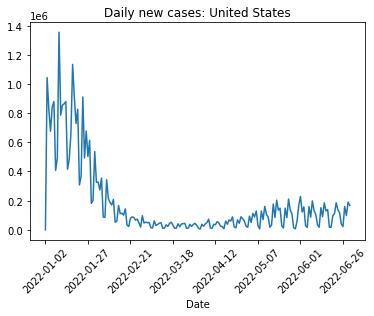

In [8]:
country_df.plot(title=f'Daily new cases: {country}',
                       x='Date', y='NewCases',
                       legend=False, rot=45)

# Prediction task

## Form the train/ val split for model debugging.

A random split of countries is created for debugging the model.

In [9]:
def split_by_country(df, split=0.2):
    """Splits the dataframe into two. This will select countries randomly
    and include a certain number in the first split and the rest in the other.
    
    Arguments:
        df (pd.DataFrame): The data to divide into two.
        split (float): The portion of data to be used in the first split."""
    countries = df["CountryName"].unique()
    np.random.shuffle(countries)
    thresh = int(len(countries) * split)
    countries_trn = countries[:thresh]
    countries_val = countries[thresh:]
    df_trn = df[df["CountryName"].isin(countries_trn)]
    df_val = df[df["CountryName"].isin(countries_val)]
    return df_trn, df_val

df_trn, df_val = split_by_country(df, 0.8)

## Pre-process the training/ validation data.
The data is currently a pandas DataFrame representing a table with many columns. We reduce this table to the relevant information and format the data to be usable by the prediction model using a **sliding window**.

In [10]:
"""
NOTE:
1. This function is a simple method for pre-processing the data.
2. You may consider playing around with the function to engineer better features.
   This is just a suggestion, and is not necessary for receiving full credit.
"""
def process_data(days_ahead, lookback_days, df, cases_col, ip_cols):
    """Runs a sliding window across the input data to generate training samples.
    Each training sample is a vector consisting:
        (1) daily case data for a number of days equal to lookback_days.
        (2) daily IP data covering the same range as the daily case data,
            plus a number of days equal to days_ahead.
    The corresponding labels are the number of new cases starting the day after 
    the end of the input case data and ending on the final day of IP data.
    
    Specifically, for any valid day d:
        the cases are from days { d-lookback_days, ..., d-1 };
        the IPs are from days { d-lookback_days, ..., d, d+1, ..., d+days_ahead-1 };
        and the labels are for days { d, d+1, ..., d+days_ahead-1 }.
    
    Any given sample includes data from only one single GeoID.
    
    Arguments:
        days_ahead (int): A value 1 or above indicating the number of days ahead
            to predict past the end of the case data.
        lookback_days (int): A value 0 or above indicating the number of days
            of case data included.
        df (pandas.DataFrame): The dataframe to extract these features from.
        cases_col (str): The name of the DataFrame column corresponding
            to the case data.
        ip_cols (List[str]): The names of the DataFrame columns corresponding
            to the intervention plan data.
        
    Returns: A tuple (features, labels):
        features is an ndarray of shape (Samples, Features);
        labels is an ndarray of shape (Samples, PredictDays)"""
    X_samples = []
    y_samples = []
    countries = df["CountryName"].unique()
    for country in countries:
        cdf = df[df["CountryName"] == country]
        all_case_data = np.array(cdf[cases_col], dtype=np.float32) # shape (Days,)
        all_ip_data = np.array(cdf[ip_cols], dtype=np.float32) # shape (Days, IPs)
        
        # Create one sample for each day where we have enough data
        total_days = len(cdf)
        for d in range(lookback_days, total_days - days_ahead):
            # Select the window
            X_cases = all_case_data[d - lookback_days:d]
            X_ips = all_ip_data[d - lookback_days:d + days_ahead]
            y_sample = all_case_data[d: d + days_ahead]

            # Flatten the daily data into one vector
            X_sample = np.concatenate([X_cases.flatten(),
                                       X_ips.flatten()])
            
            # Add it to the list of training samples
            X_samples.append(X_sample)
            y_samples.append(y_sample)

    X_samples = np.array(X_samples)
    y_samples = np.array(y_samples)
    
    return X_samples, y_samples

In [11]:
DAYS_AHEAD = 10
LOOKBACK_DAYS = 30
CASES_COLUMN = "NewCases"

X_trn, y_trn = process_data(DAYS_AHEAD, LOOKBACK_DAYS, df_trn, CASES_COLUMN, IP_COLUMNS)
X_val, y_val = process_data(DAYS_AHEAD, LOOKBACK_DAYS, df_val, CASES_COLUMN, IP_COLUMNS)

In [12]:
print(f'There are {X_trn.shape[0]} training samples, and each has {X_trn.shape[1]} feature dimensions.')
print(f'There are {X_val.shape[0]} validation samples.')
print(f'For each of the {y_trn.shape[0]} training samples, ' +
      f'there are {y_trn.shape[1]} days of cases to predict.')
print(f'There are {DAYS_AHEAD + LOOKBACK_DAYS} days of IP data, and {LOOKBACK_DAYS} days of case data, ' +
      f'making up {(DAYS_AHEAD + LOOKBACK_DAYS) * len(IP_COLUMNS) + LOOKBACK_DAYS} dimensions.')

There are 20860 training samples, and each has 470 feature dimensions.
There are 5320 validation samples.
For each of the 20860 training samples, there are 10 days of cases to predict.
There are 40 days of IP data, and 30 days of case data, making up 470 dimensions.


## Define the model

Below is a linear regression model. Using Pytorch to train a linear regression model is not necessary, but this code is meant to be a placeholder for your design.

Modify this class to create your neural network model.

In [13]:
#class LinearRegressionModel(torch.nn.Module):
#    def __init__(self, inputSize, outputSize):
#        super(LinearRegressionModel, self).__init__()
#        self.linear = torch.nn.Linear(inputSize, outputSize)

#    def forward(self, x):
#        out = self.linear(x)
#        return out

#class NeuralNetwork(nn.Module):
#    def __init__(self, inputSize, outputSize):
#        super(NeuralNetwork, self).__init__()
#        self.flatten = nn.Flatten()
#        self.linear_relu_stack = nn.Sequential(
#            nn.Linear(inputSize, 512),
#            nn.ReLU(),
#            nn.Linear(512, 512),
#            nn.ReLU(),
#            nn.Linear(512, outputSize),
#        )

#    def forward(self, x):
#        x = self.flatten(x)
#        logits = self.linear_relu_stack(x)
#        return logits

class LinearRegressionModel(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(inputSize, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.Dropout(),
            nn.Linear(512,1024),
            nn.ReLU(),
            nn.Linear(1024, outputSize),
        )

    def forward(self, x):
        out = self.linear(x)
        return out


## Train the model

Below is a standard training loop, featuring validation / training sets, and gradient descent.

You may consider changing the hyper-parameters, implementing mini-batching, introducing regularization schemes, and other optimizers.

In [14]:
def train_model(X_trn, y_trn, X_val, y_val, model):    

    # Define training parameters.
    # These are intentionally left untuned!
    learning_rate = 1e-10
    n_epochs = 100
    l1_lambda = 0.1
    criterion = torch.nn.MSELoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    #optimizer = torch.optim.ASGD(model.parameters(), lr=learning_rate)

    # Initialize logging
    train_loss_log = []
    val_loss_log = []

    for epoch in range(n_epochs):
        # Converting inputs and labels to Variable
        inputs = Variable(torch.from_numpy(X_trn))
        labels = Variable(torch.from_numpy(y_trn))

        optimizer.zero_grad()

        # get output from the model, given the inputs.
        outputs = model(inputs)

        # compute loss, including l1 regularization.
        model_loss = criterion(outputs, labels)
        l1_loss = sum(p.abs().sum() for p in model.parameters())
        loss = model_loss + l1_lambda*l1_loss

        # detach training loss for printing and logging.
        trn_loss = loss.detach().numpy()
        print(loss)
        
        # get gradients w.r.t to parameters
        loss.backward()

        # update parameters
        optimizer.step()

        ## logging: compute validation loss
        val_pred = model(torch.from_numpy(X_val))
        val_model_loss = criterion(val_pred, torch.from_numpy(y_val))
        val_l1_loss = sum(p.abs().sum() for p in model.parameters())
        val_loss = (val_model_loss + l1_lambda*val_l1_loss).detach().numpy()

        print('epoch {}, loss {}'.format(epoch, loss.item()))
        
        ## Logging
        train_loss_log.append(trn_loss)
        val_loss_log.append(val_loss)
        
        print('Epoch {}: Train Loss {:.2f}\tVal Loss {:.2f}'.format(epoch, trn_loss, val_loss))

    return model, train_loss_log, val_loss_log

The following cell executes the train function, and it might take a while to execute.

In [15]:
MODEL_FILE = "./logs/model.pt"
TRAIN_LOG_FILE = "./logs/train_log.pkl"

# Create an instance of the model.
n_features = X_trn.shape[1]
n_predictions = y_trn.shape[1]
   
model = LinearRegressionModel(n_features, n_predictions)
#model = NeuralNetwork(n_features, n_predictions)
model, train_loss_log, val_loss_log = train_model(X_trn, y_trn, X_val, y_val, model)

# Save the weights and logs
torch.save(model.state_dict(), MODEL_FILE)

with open(TRAIN_LOG_FILE, 'wb') as f:
    pickle.dump(train_loss_log, f)

tensor(5.5253e+08, grad_fn=<AddBackward0>)
epoch 0, loss 552525184.0
Epoch 0: Train Loss 552525184.00	Val Loss 937008768.00
tensor(5.3750e+08, grad_fn=<AddBackward0>)
epoch 1, loss 537502080.0
Epoch 1: Train Loss 537502080.00	Val Loss 917533568.00
tensor(5.2334e+08, grad_fn=<AddBackward0>)
epoch 2, loss 523342880.0
Epoch 2: Train Loss 523342880.00	Val Loss 898045824.00
tensor(5.0924e+08, grad_fn=<AddBackward0>)
epoch 3, loss 509244256.0
Epoch 3: Train Loss 509244256.00	Val Loss 877852800.00
tensor(4.9497e+08, grad_fn=<AddBackward0>)
epoch 4, loss 494965792.0
Epoch 4: Train Loss 494965792.00	Val Loss 856210496.00
tensor(4.7960e+08, grad_fn=<AddBackward0>)
epoch 5, loss 479600256.0
Epoch 5: Train Loss 479600256.00	Val Loss 831829824.00
tensor(4.6297e+08, grad_fn=<AddBackward0>)
epoch 6, loss 462972384.0
Epoch 6: Train Loss 462972384.00	Val Loss 801206592.00
tensor(4.4433e+08, grad_fn=<AddBackward0>)
epoch 7, loss 444325152.0
Epoch 7: Train Loss 444325152.00	Val Loss 771721728.00
tensor(4

epoch 65, loss 159499648.0
Epoch 65: Train Loss 159499648.00	Val Loss 174635984.00
tensor(1.6070e+08, grad_fn=<AddBackward0>)
epoch 66, loss 160695024.0
Epoch 66: Train Loss 160695024.00	Val Loss 180970352.00
tensor(1.5787e+08, grad_fn=<AddBackward0>)
epoch 67, loss 157869840.0
Epoch 67: Train Loss 157869840.00	Val Loss 169713376.00
tensor(1.5828e+08, grad_fn=<AddBackward0>)
epoch 68, loss 158275488.0
Epoch 68: Train Loss 158275488.00	Val Loss 166262976.00
tensor(1.5595e+08, grad_fn=<AddBackward0>)
epoch 69, loss 155950880.0
Epoch 69: Train Loss 155950880.00	Val Loss 167173936.00
tensor(1.5728e+08, grad_fn=<AddBackward0>)
epoch 70, loss 157276800.0
Epoch 70: Train Loss 157276800.00	Val Loss 165879776.00
tensor(1.5650e+08, grad_fn=<AddBackward0>)
epoch 71, loss 156499216.0
Epoch 71: Train Loss 156499216.00	Val Loss 160200640.00
tensor(1.5462e+08, grad_fn=<AddBackward0>)
epoch 72, loss 154616336.0
Epoch 72: Train Loss 154616336.00	Val Loss 159012576.00
tensor(1.5448e+08, grad_fn=<AddBack

## Evaluate the model


### Training curve
The training curve shows the progression of model performance over the course of training.

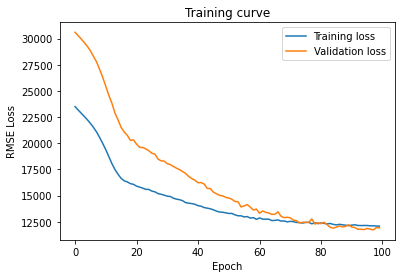

In [16]:
plt.figure()
plt.title('Training curve')
plt.xlabel('Epoch')
plt.ylabel('RMSE Loss')

# Convert the MSE loss values to RMSE
rmse_train_loss_log = np.sqrt(train_loss_log)
rmse_val_loss_log = np.sqrt(val_loss_log)

plt.plot(rmse_train_loss_log, label='Training loss')
plt.plot(rmse_val_loss_log, label='Validation loss')
plt.legend()

## This is the holdout data for submitting predictions.

In [17]:
HOLDOUT_FILE = "./data/tst_data.csv"
df_tst = pd.read_csv(HOLDOUT_FILE, parse_dates=["Date"])

# Create NewCases column.
df_tst["NewCases"] = df_tst.groupby(["CountryName"])["ConfirmedCases"].diff().fillna(0)

# Fill any missing case values by interpolation and setting NaNs to 0
df_tst.update(df_tst.groupby("CountryName")["NewCases"].apply(
     lambda group: group.interpolate()).fillna(0))

X_tst, y_tst = process_data(DAYS_AHEAD, LOOKBACK_DAYS, df_tst, CASES_COLUMN, IP_COLUMNS)

countries = list(df_tst["CountryName"].unique())

# Final predictions

Is your model ready to submit? If so, then this cell will evaluate its predictions on the test set. 

Making predictions means saving a .csv file called "final_predictions.csv" to the root folder.



In [18]:
"""
Reports the model's MSE over the test data (without L1 regularization).
Generates a file with predicted new cases for all countries.
"""
PREDICTIONS_FILE = "./logs/output.csv"

tst_pred = model(torch.from_numpy(X_tst)).detach().numpy()
np.savetxt(PREDICTIONS_FILE, tst_pred, delimiter=',')